In [4]:
# Import required libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download VADER lexicon
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rabia/nltk_data...


True

In [5]:
# Define URLs and tickers
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['MSFT', 'GOOG', 'TSLA']

# Scrape news data
news_tables = {}
for ticker in tickers:
    try:
        url = finviz_url + ticker
        req = Request(url=url, headers={'user-agent': 'Mozilla/5.0'})
        response = urlopen(req)
        
        html = BeautifulSoup(response, 'html.parser')
        news_table = html.find(id='news-table')
        if news_table:
            news_tables[ticker] = news_table
        else:
            print(f'No news table found for {ticker}')
    except Exception as e:
        print(f'Error fetching data for {ticker}: {str(e)}')



In [ ]:
# Parse the scraped data
parsed_data = []
from datetime import datetime, timedelta

today = datetime.now().date()
yesterday = today - timedelta(days=1)

for ticker, news_table in news_tables.items():
    # Use find_all instead of findAll (deprecated)
    rows = news_table.find_all('tr')
    
    for row in rows:
        try:
            # Extract title
            title = row.a.text if row.a else ''
            
            # Extract date and time
            date_cell = row.td.text.strip() if row.td else ''
            if date_cell:
                date_parts = date_cell.split()
                
                # Handle relative dates
                if 'Today' in date_parts[0]:
                    date = today.strftime('%Y-%m-%d')
                elif 'Yesterday' in date_parts[0]:
                    date = yesterday.strftime('%Y-%m-%d')
                else:
                    # If it's a regular date (e.g., "Feb-20-24")
                    try:
                        date = datetime.strptime(date_parts[0], '%b-%d-%y').strftime('%Y-%m-%d')
                    except ValueError:
                        # Use the date from the previous row if parsing fails
                        date = parsed_data[-1][1] if parsed_data else today.strftime('%Y-%m-%d')
                
                # Extract time
                time = date_parts[-1] if len(date_parts) > 1 else '00:00'
                
                if title and date:  # Only append if we have both title and date
                    parsed_data.append([ticker, date, time, title])
        except Exception as e:
            print(f'Error parsing row for {ticker}: {str(e)}')
            continue

# Create DataFrame
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
print(f'Total news items collected: {len(df)}')
df.head()  # Display first few rows


Total news items collected: 300


,ticker,date,time,title
0,MSFT,Today,10:25AM,"AI gives stocks a lift, dollar mixed tracking ..."
1,MSFT,Today,10:16AM,Microsoft's market cap surpasses $4 trillion m...
2,MSFT,Today,10:16AM,Microsoft Joins Nvidia in $4 Trillion Club
3,MSFT,Today,10:11AM,Nvidia Stock Hits New Record High After Micros...
4,MSFT,Today,10:10AM,Microsoft Surges to $4 Trillion Market Cap Aft...


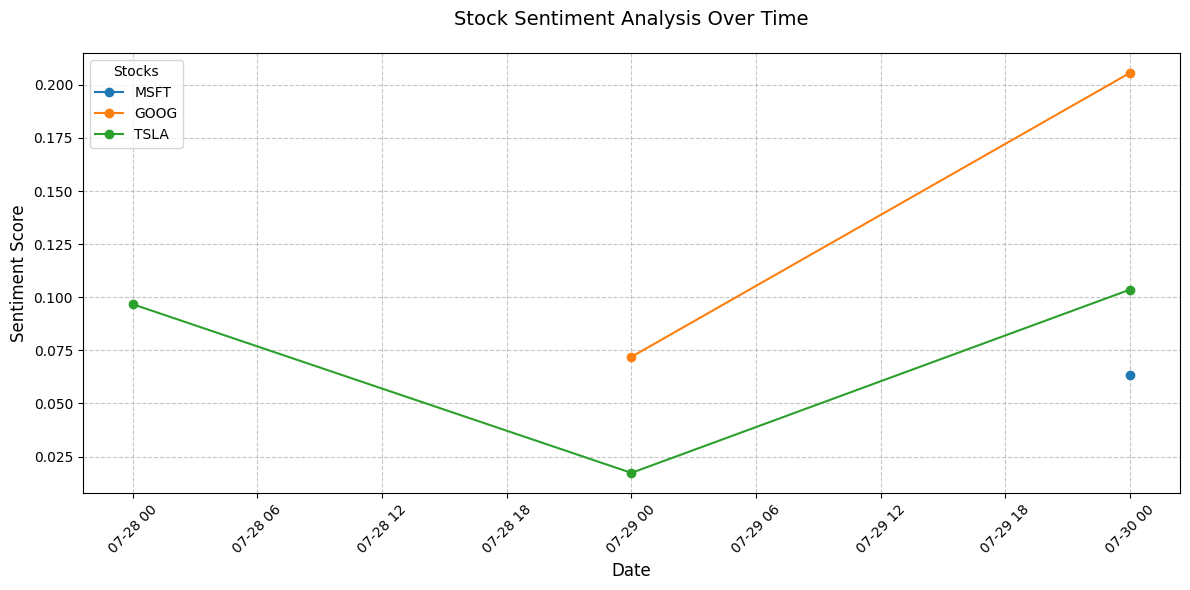


Sentiment Summary by Stock:
         mean    min    max    std
ticker                            
GOOG    0.166 -0.625  0.827  0.312
MSFT    0.064 -0.557  0.848  0.430
TSLA    0.075 -0.710  0.758  0.299

Sample Headlines and Their Sentiment:

TSLA (2025-07-28):
Headline: Trump Locks $750B Energy Deal with EU--But the Numbers Don't Add Up
Sentiment: positive (score: 0.273)

TSLA (2025-07-30):
Headline: Twenty One Boosting Bitcoin Holdings; CEO Jack Mallers Sees $150K BTC Incoming
Sentiment: positive (score: 0.340)

TSLA (2025-07-30):
Headline: Tesla Stock Fell. What a New Battery Supplier Might Matter for Tariffs.
Sentiment: positive (score: 0.026)

TSLA (2025-07-28):
Headline: These Stocks Are Moving the Most Today: Tesla, AMD, ASML, Nike, Revvity, Charter, and More
Sentiment: neutral (score: 0.000)

MSFT (2025-07-30):
Headline: Strong earnings from Meta, Microsoft but misses 1 critical metric
Sentiment: negative (score: -0.485)


In [20]:
# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

try:
    # Calculate sentiment scores
    df['compound'] = df['title'].apply(lambda x: vader.polarity_scores(str(x))['compound'])

    # Ensure date column is properly formatted
    df['date'] = pd.to_datetime(df['date'], format='%b-%d-%y', errors='coerce').dt.date
    
    # Drop rows with invalid dates
    df = df.dropna(subset=['date'])
    
    # Sort DataFrame by date
    df = df.sort_values('date')

    # Calculate mean sentiment per ticker and date
    mean_sentiment = df.groupby(['ticker', 'date'])['compound'].mean().reset_index()

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot for each ticker
    for ticker in tickers:
        ticker_data = mean_sentiment[mean_sentiment['ticker'] == ticker]
        if not ticker_data.empty:
            plt.plot(ticker_data['date'], ticker_data['compound'], marker='o', label=ticker)

    # Customize the plot
    plt.title('Stock Sentiment Analysis Over Time', fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sentiment Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Stocks')

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print summary statistics
    print('\nSentiment Summary by Stock:')
    summary = df.groupby('ticker')['compound'].agg(['mean', 'min', 'max', 'std']).round(3)
    print(summary)

    # Print sample of analyzed headlines
    print('\nSample Headlines and Their Sentiment:')
    sample_df = df[['ticker', 'date', 'title', 'compound']].sample(min(5, len(df)))
    for _, row in sample_df.iterrows():
        sentiment = 'positive' if row['compound'] > 0 else 'negative' if row['compound'] < 0 else 'neutral'
        print(f"\n{row['ticker']} ({row['date']}):")
        print(f"Headline: {row['title']}")
        print(f"Sentiment: {sentiment} (score: {row['compound']:.3f})")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("\nDataFrame head for debugging:")
    print(df.head())
    print("\nUnique date values:")
    print(df['date'].unique())
